In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.use('pdf')
import sys
sys.path.append("../")
import copy
from Plotting.generate_database import ResultsDatabaseGenerator
from common_packages.utilities import get_equivalent_classical_layer_size, get_num_parameters_per_quantum_layer
from Plotting.Plot import BasicPlot, MultiPlot
import pandas as pd
colors =   ["#5dd448",
            "#bfa900",
            "#ec742f",
            "#e9496f",
            "#b04ca4",]

colors = ["#332288", "#88CCEE", "#44AA99", "#117733", "#999933", "#DDCC77", "#CC6677", "#882255", "#AA4499"]
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 12
plt.rcParams["axes.linewidth"] = 0.5

%load_ext autoreload
%autoreload 2

2023-07-04 15:58:59.173984: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-07-04 15:58:59.174129: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
%matplotlib inline
ex_path = "Synthetic_Hybrid_PWB_Experiment"
dbGen = ResultsDatabaseGenerator()
dbGen.initialize_from_folder(ex_path)
data = dbGen.data
config = data[6]['config']
config.pop('__doc__', None)
df = pd.DataFrame(columns=config.keys())
df['avg_acc'] = np.nan
df['acc_err'] = np.nan
df['avg_loss'] = np.nan
df['loss_err'] = np.nan
for i in range(1, len(data) + 1):
    config = data[i]['config']
    config.pop('__doc__', None)
    metrics = data[i]['metrics']
    metrics.pop('epoch',None)
    acc, loss = metrics.values()
    avg_acc = np.mean(acc)
    acc_err = np.std(acc)
    avg_loss = np.mean(loss)
    loss_err = np.std(loss)
    df.loc[i] = [*config.values(), avg_acc, acc_err, avg_loss, loss_err]
   
    
df = df.sort_values('sigma')
x = np.array(df['sigma'].unique()).astype(float)
x = np.log2(1+1/x)
plot_df = pd.DataFrame(index=x)

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(6,6), sharex=True, sharey=True)
fig.supxlabel('Precision (Bits)')
fig.suptitle('Synthetic Dataset Accuracy Comparison')
for i in range(2,5):

    mask = (df['network_type']=='quantum') & (df['num_qumodes']==i)

    x1 = np.array(df[mask]['sigma'].unique()).astype(float)
    x1 = np.log2(1+1/x1)

    acc_q = df[mask]['avg_acc']
    acc_err_q = df[mask]['acc_err']
    loss_q = df[mask]['avg_loss']
    loss_err_q = df[mask]['loss_err']

    mask = (df['network_type']=='classical') & (df['num_qumodes']==i)

    x2 = np.array(df[mask]['sigma'].unique()).astype(float)
    x2 = np.log2(1+1/x2)
    
    acc_c = df[mask]['avg_acc']
    acc_err_c = df[mask]['acc_err']
    loss_c = df[mask]['avg_loss']
    loss_err_c = df[mask]['loss_err']
    
    mask = (df['network_type']=='classical_tf') & (df['num_qumodes']==i)

    x3 = np.array(df[mask]['sigma'].unique()).astype(float)
    x3 = np.log2(1+1/x3)
    
    acc_tf = df[mask]['avg_acc']
    acc_err_tf = df[mask]['acc_err']
    loss_tf = df[mask]['avg_loss']
    loss_err_tf = df[mask]['loss_err']
    
    #ax[i-2].grid(True, linestyle=':')
    line_q = ax[i-2].plot(x1, acc_q, label='Hybrid', alpha=0.8)
    ax[i-2].fill_between(x1, acc_q - acc_err_q, acc_q + acc_err_q, interpolate=True, alpha=0.3)
    
    line_c = ax[i-2].plot(x2, acc_c, label='Classical', alpha=0.8)
    ax[i-2].fill_between(x2, acc_c - acc_err_c, acc_c + acc_err_c, interpolate=True, alpha=0.3)
    ax[i-2].set_title(f'{i} Qumode')
    
    line_tf = ax[i-2].plot(x3, acc_tf, label='TF', alpha=0.8)
    ax[i-2].fill_between(x3, acc_tf - acc_err_tf, acc_tf + acc_err_tf, interpolate=True, alpha=0.3)
    ax[i-2].hlines([0.9,0.9], 1, 10, color=colors[5], linestyles='--')
    
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc=5)
plt.savefig('../MidWinter/Synthetic_comparison.pdf')

FileNotFoundError: [Errno 2] No such file or directory: 'Synthetic_Hybrid_PWB_Experiment'

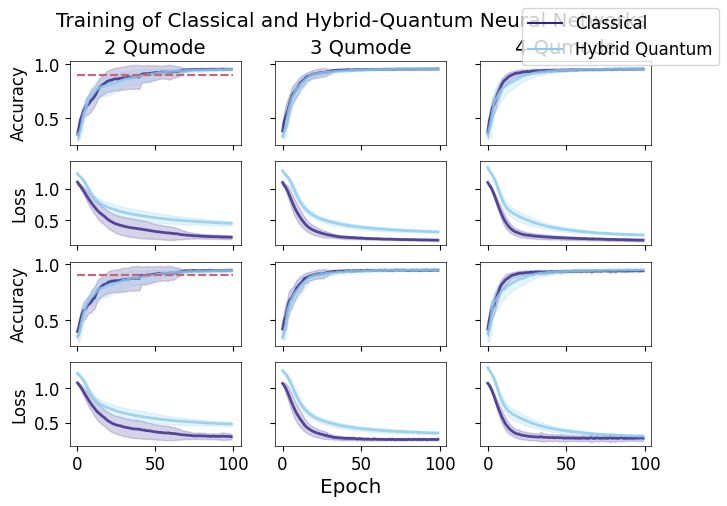

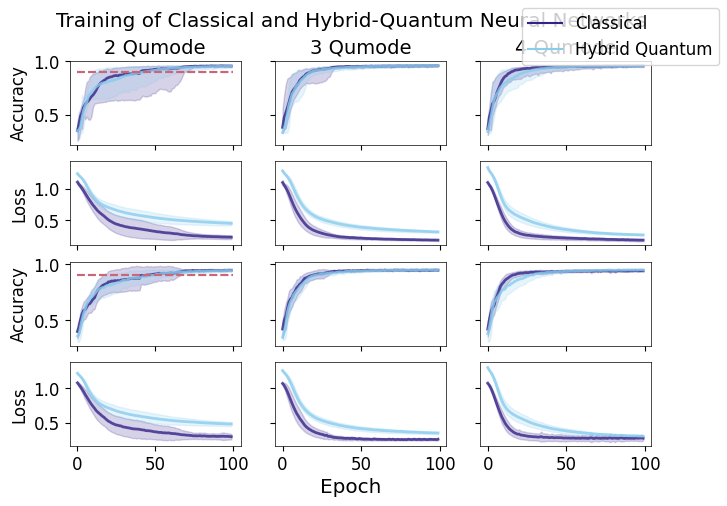

In [ ]:
ex_path = "Synthetic_Hybrid_Base_Experiment_100Epochs_2"
dbGen = ResultsDatabaseGenerator()
dbGen.initialize_from_folder(ex_path)
data = dbGen.data
config = data[1]['config']
config.pop('__doc__', None)
#config.pop('iteration', None)
df = pd.DataFrame(columns=config.keys())
df['acc'] = np.nan
df['val_acc'] = np.nan
df['loss'] = np.nan
df['val_loss'] = np.nan
for i in range(1, len(data) + 1):
    try:
        config = data[i]['config']
        config.pop('__doc__', None)
        #config.pop('iteration', None)
        metrics = data[i]['metrics']
        metrics.pop('epoch',None)
        acc, loss, val_acc, val_loss = metrics.values()
        acc = np.array(acc)
        assert acc.shape[-1] == 100
        loss = np.array(loss)
        val_acc = np.array(val_acc)
        val_loss = np.array(val_loss)
        df.loc[i] = [*config.values(), acc, val_acc, loss, val_loss]
    except (KeyError, AssertionError):
        print(f"Invalid: {i}")
#df = df.explode(column=['acc', 'val_acc', 'loss', 'val_loss'])
df_mean =df.groupby(['network_type', 'num_qumodes']).apply(lambda x: pd.DataFrame({
    'acc': [np.mean(x['acc'].tolist(), axis=0)],
    'val_acc': [np.mean(x['val_acc'].tolist(), axis=0)],
    'loss': [np.mean(x['loss'].tolist(), axis=0)],
    'val_loss': [np.mean(x['val_loss'].tolist(), axis=0)]
}))
df_mean.reset_index()
"""df_std = df.groupby(['network_type', 'num_qumodes']).apply(
    lambda x: x[['acc','val_acc', 'loss', 'val_loss']].apply(
        lambda y: np.std(y)).rename(columns={
            'acc' : 'acc_std','val_acc':'val_acc_std', 'loss':'loss_std', 'val_loss':'val_loss_std'}))
"""
df_std =df.groupby(['network_type', 'num_qumodes']).apply(lambda x: pd.DataFrame({
    'acc': [np.std(x['acc'].tolist(), axis=0)],
    'val_acc': [np.std(x['val_acc'].tolist(), axis=0)],
    'loss': [np.std(x['loss'].tolist(), axis=0)],
    'val_loss': [np.std(x['val_loss'].tolist(), axis=0)]
}))
df_std.reset_index()

df_min =df.groupby(['network_type', 'num_qumodes']).apply(lambda x: pd.DataFrame({
    'acc': [np.min(x['acc'].tolist(), axis=0)],
    'val_acc': [np.min(x['val_acc'].tolist(), axis=0)],
    'loss': [np.min(x['loss'].tolist(), axis=0)],
    'val_loss': [np.min(x['val_loss'].tolist(), axis=0)]
}))
df_min.reset_index()
df_max =df.groupby(['network_type', 'num_qumodes']).apply(lambda x: pd.DataFrame({
    'acc': [np.max(x['acc'].tolist(), axis=0)],
    'val_acc': [np.max(x['val_acc'].tolist(), axis=0)],
    'loss': [np.max(x['loss'].tolist(), axis=0)],
    'val_loss': [np.max(x['val_loss'].tolist(), axis=0)]
}))
df_max.reset_index()
#df_std.pop(column=3)
#display(df[(df['network_type'] == 'classical') & (df['num_qumodes']==2)])
#fig, ax = plt.subplots(figsize=(8,6))

names = [f'Classical: {get_equivalent_classical_layer_size(i, 2*i, 3)*2*i + 3} parameters' for i in range(2, 5)] \
    + [f'Quantum: {int(get_num_parameters_per_quantum_layer(i))} parameters' for i in range(2, 5)]

q_or_c = ['Classical' for i in range(3)] + ['Quantum' for i in range(3)]
fig, ax = plt.subplots(ncols=3, nrows=4, figsize=(7.5, 5), sharey='row', sharex='col')
for i, (mean, std) in enumerate(zip(df_mean['acc'], df_std['acc'])):
    x = np.arange(len(mean))
    y = mean
    std = std
    ax[0,i%3].plot(x, y, lw=2, color=colors[i//3], alpha=0.8, )
    ax[0,i%3].fill_between(x, y - std, y + std, color=colors[i//3], alpha=0.2)

for i, (mean, std) in enumerate(zip(df_mean['loss'], df_std['loss'])):
    x = np.arange(len(mean))
    y = mean
    std = std
    ax[1,i%3].plot(x, y, lw=2, alpha=0.8, color=colors[i//3], )
    ax[1,i%3].fill_between(x, y - std, y + std, color=colors[i//3], alpha=0.2)

for i, (mean, std) in enumerate(zip(df_mean['val_acc'], df_std['val_acc'])):
    x = np.arange(len(mean))
    y = mean
    std = std
    ax[2,i%3].plot(x, y, lw=2, color=colors[i//3], alpha=0.8, )
    ax[2,i%3].fill_between(x, y - std, y + std, color=colors[i//3], alpha=0.2)

for i, (mean, std) in enumerate(zip(df_mean['val_loss'], df_std['val_loss'])):
    x = np.arange(len(mean))
    y = mean
    std = std
    ax[3,i%3].plot(x, y, lw=2, alpha=0.8, color=colors[i//3], )
    ax[3,i%3].fill_between(x, y - std, y + std, color=colors[i//3], alpha=0.2)

fig.supxlabel('Epoch')
for j,i in enumerate(ax[0]):
    i.set_title(f'{j+2} Qumode', fontsize=14)
ax[0,0].hlines([0.9, 0.9], xmin=0, xmax=100, color=colors[6], linestyles='--')
ax[2,0].hlines([0.9, 0.9], xmin=0, xmax=100, color=colors[6], linestyles='--')
ax[0,0].set_ylabel('Accuracy')
ax[1,0].set_ylabel('Loss')
ax[2,0].set_ylabel('Accuracy')
ax[3,0].set_ylabel('Loss')
plt.plot([], color=colors[0], label='Classical')
plt.plot([], color=colors[1], label='Hybrid Quantum')
fig.legend()
fig.suptitle('Training of Classical and Hybrid-Quantum Neural Networks')
plt.savefig('HybridTraining.pdf')
plt.show()

fig, ax = plt.subplots(ncols=3, nrows=4, figsize=(7.5, 5), sharey='row', sharex='col')
for i, (mean, accmin, accmax) in enumerate(zip(df_mean['acc'], df_min['acc'], df_max['acc'])):
    x = np.arange(len(mean))
    y = mean
    std = std
    ax[0,i%3].plot(x, y, lw=2, color=colors[i//3], alpha=0.8, )
    ax[0,i%3].fill_between(x, accmin, accmax, color=colors[i//3], alpha=0.2)

for i, (mean, std) in enumerate(zip(df_mean['loss'], df_std['loss'])):
    x = np.arange(len(mean))
    y = mean
    std = std
    ax[1,i%3].plot(x, y, lw=2, alpha=0.8, color=colors[i//3], )
    ax[1,i%3].fill_between(x, y - std, y + std, color=colors[i//3], alpha=0.2)

for i, (mean, std) in enumerate(zip(df_mean['val_acc'], df_std['val_acc'])):
    x = np.arange(len(mean))
    y = mean
    std = std
    ax[2,i%3].plot(x, y, lw=2, color=colors[i//3], alpha=0.8, )
    ax[2,i%3].fill_between(x, y - std, y + std, color=colors[i//3], alpha=0.2)

for i, (mean, std) in enumerate(zip(df_mean['val_loss'], df_std['val_loss'])):
    x = np.arange(len(mean))
    y = mean
    std = std
    ax[3,i%3].plot(x, y, lw=2, alpha=0.8, color=colors[i//3], )
    ax[3,i%3].fill_between(x, y - std, y + std, color=colors[i//3], alpha=0.2)

fig.supxlabel('Epoch')
for j,i in enumerate(ax[0]):
    i.set_title(f'{j+2} Qumode', fontsize=14)
ax[0,0].hlines([0.9, 0.9], xmin=0, xmax=100, color=colors[6], linestyles='--')
ax[2,0].hlines([0.9, 0.9], xmin=0, xmax=100, color=colors[6], linestyles='--')
ax[0,0].set_ylabel('Accuracy')
ax[1,0].set_ylabel('Loss')
ax[2,0].set_ylabel('Accuracy')
ax[3,0].set_ylabel('Loss')
plt.plot([], color=colors[0], label='Classical')
plt.plot([], color=colors[1], label='Hybrid Quantum')
fig.legend()
fig.suptitle('Training of Classical and Hybrid-Quantum Neural Networks')
plt.savefig('HybridTraining.pdf')
plt.show()




Inconsistent config parameter val_accuracy!=num_params found in experiment folder between file and reference 27. Ignoring experiment...
Inconsistent config parameter val_accuracy!=num_params found in experiment folder between file and reference 26. Ignoring experiment...


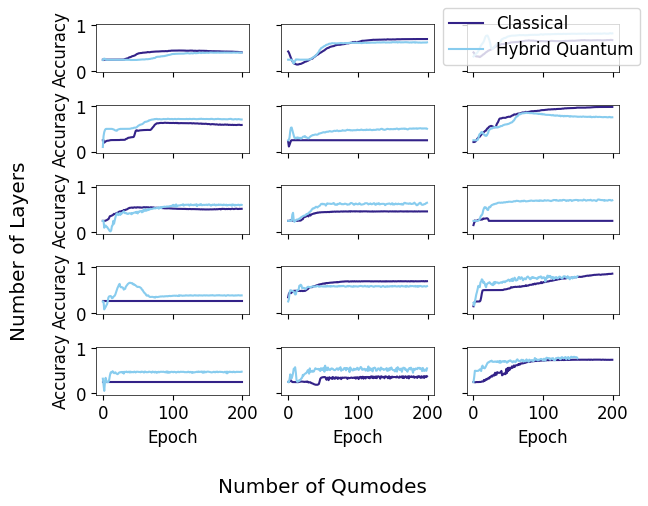

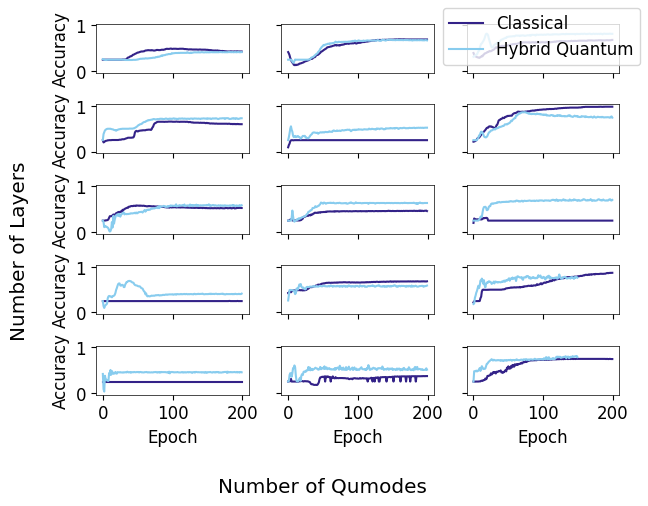

In [ ]:
%matplotlib inline
ex_path = "./Synthetic_Quantum_Base_Experiment2"
dbGen = ResultsDatabaseGenerator()
dbGen.initialize_from_folder(ex_path)
data = dbGen.data
config = data[1]['config']
config.pop('__doc__', None)
#config.pop('iteration', None)
df = pd.DataFrame(columns=config.keys())
df['num_params'] = np.nan
df['acc'] = np.nan
df['val_acc'] = np.nan
df['loss'] = np.nan
df['val_loss'] = np.nan
for i in data.keys():
    config = data[i]['config']
    config.pop('__doc__', None)
    metrics = data[i]['metrics']
    metrics.pop('epoch',None)
    acc, loss, num_params, val_acc, val_loss = metrics.values()
    acc = np.array(acc)
    loss = np.array(loss)
    val_acc = np.array(val_acc)
    val_loss = np.array(val_loss)
    df.loc[i] = [*config.values(), num_params[0], acc, val_acc, loss, val_loss]
        
df.sort_values('network_type',inplace=True)
fig, ax = plt.subplots(nrows=df['n_layers'].max(), ncols=df['num_qumodes'].max()-1, figsize=(6.5,5), sharex=True, sharey=True)
for i, row in df.iterrows():
    vals = row['acc']
    idx_row = row['n_layers'] - 1
    idx_col = row['num_qumodes'] - 2
    ax[idx_row, idx_col].plot(vals)
    ax[-1,idx_col].set_xlabel('Epoch')
    ax[idx_row,0].set_ylabel('Accuracy')
fig.supylabel('Number of Layers')
fig.supxlabel('Number of Qumodes')
plt.plot([], color=colors[0], label='Classical')
plt.plot([], color=colors[1], label='Hybrid Quantum')
fig.legend()
fig.tight_layout()
plt.savefig('Training_Nlayers.png')

plt.show()
fig, ax = plt.subplots(nrows=df['n_layers'].max(), ncols=df['num_qumodes'].max()-1, figsize=(6.5,5), sharex=True, sharey=True)
for i, row in df.iterrows():
    vals = row['val_acc']
    idx_row = row['n_layers'] - 1
    idx_col = row['num_qumodes'] - 2
    ax[idx_row, idx_col].plot(vals)
    ax[-1,idx_col].set_xlabel('Epoch')
    ax[idx_row,0].set_ylabel('Accuracy')
fig.supylabel('Number of Layers')
fig.supxlabel('Number of Qumodes')
plt.plot([], color=colors[0], label='Classical')
plt.plot([], color=colors[1], label='Hybrid Quantum')
fig.legend()
fig.tight_layout()
plt.savefig('Validation_Nlayers.png')
plt.show()

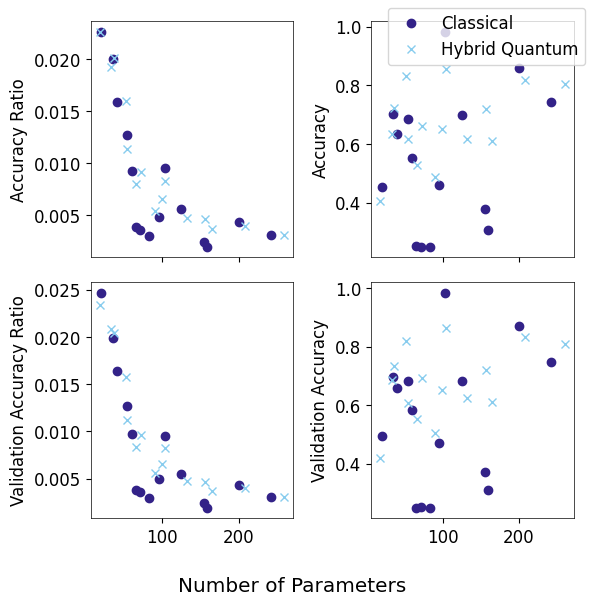

In [ ]:
#display(df)
df_max = copy.deepcopy(df)
#display(df_max['acc'])
df_max['acc'] = df_max['acc'].apply(lambda x: np.max(x))
df_max['val_acc'] = df_max['val_acc'].apply(lambda x: np.max(x))
df_max['loss'] = df_max['loss'].apply(lambda x: np.max(x))
df_max['val_loss'] = df_max['val_loss'].apply(lambda x: np.max(x))
df_max['acc_ratio'] = df_max['acc']/df_max['num_params']
df_max['val_acc_ratio'] = df_max['val_acc']/df_max['num_params']

df_classical = df_max[df_max['network_type']=='classical']
df_quantum = df_max[df_max['network_type']=='quantum']

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(6,6), sharex=True)

x,y = df_classical['num_params'], df_classical['acc_ratio']
axs[0,0].plot(x,y, 'o', color=colors[0])
axs[0,0].set_ylabel('Accuracy Ratio')

x,y = df_quantum['num_params'], df_quantum['acc_ratio']
axs[0,0].plot(x,y, 'x', color=colors[1])

x,y = df_classical['num_params'], df_classical['val_acc_ratio']
axs[1,0].plot(x,y, 'o', color=colors[0])
axs[1,0].set_ylabel('Validation Accuracy Ratio')

x,y = df_quantum['num_params'], df_quantum['val_acc_ratio']
axs[1,0].plot(x,y, 'x', color=colors[1])

x,y = df_classical['num_params'], df_classical['acc']
axs[0,1].plot(x,y, 'o', color=colors[0])
axs[0,1].set_ylabel('Accuracy')

x,y = df_quantum['num_params'], df_quantum['acc']
axs[0,1].plot(x,y, 'x', color=colors[1])

x,y = df_classical['num_params'], df_classical['val_acc']
axs[1,1].plot(x,y, 'o', color=colors[0])
axs[1,1].set_ylabel('Validation Accuracy')

x,y = df_quantum['num_params'], df_quantum['val_acc']
axs[1,1].plot(x,y, 'x', color=colors[1])
fig.supxlabel('Number of Parameters')
plt.plot([], 'o', color=colors[0], label='Classical')
plt.plot([], 'x', color=colors[1], label='Hybrid Quantum')
fig.legend()
fig.tight_layout()

plt.savefig('AccPerParam.png')

Exception [Errno 2] No such file or directory: './Synthetic_Quantum_Base_Experiment3/213/config.json'
Error reading from config file ./Synthetic_Quantum_Base_Experiment3/213 . Ignoring file...


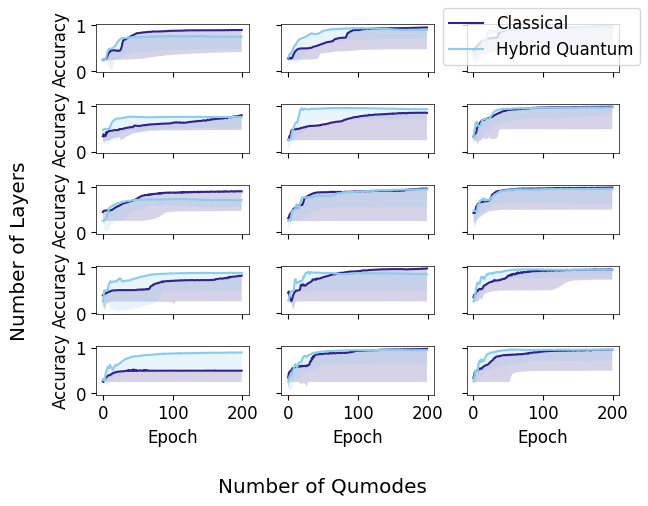

In [121]:
%matplotlib inline
ex_path = "./Synthetic_Quantum_Base_Experiment3"
dbGen = ResultsDatabaseGenerator()
dbGen.initialize_from_folder(ex_path)
data = dbGen.data
config = data[1]['config']
config.pop('__doc__', None)
#config.pop('iteration', None)
df = pd.DataFrame(columns=config.keys())
df['num_params'] = np.nan
df['acc'] = np.nan
df['val_acc'] = np.nan
df['loss'] = np.nan
df['val_loss'] = np.nan
for i in data.keys():
    config = data[i]['config']
    config.pop('__doc__', None)
    metrics = data[i]['metrics']
    metrics.pop('epoch',None)
    acc, loss, num_params, val_acc, val_loss = metrics.values()
    acc = np.array(acc)
    loss = np.array(loss)
    val_acc = np.array(val_acc)
    val_loss = np.array(val_loss)
    df.loc[i] = [*config.values(), num_params[0], acc, val_acc, loss, val_loss]

df_mean = df.groupby(['network_type', 'n_layers', 'num_qumodes', 'num_params']).apply(lambda x: pd.DataFrame({
    'acc': [np.mean(x['acc'].tolist(), axis=0)],
    'val_acc': [np.mean(x['val_acc'].tolist(), axis=0)],
    'loss': [np.mean(x['loss'].tolist(), axis=0)],
    'val_loss': [np.mean(x['val_loss'].tolist(), axis=0)]
}))
df_std =df.groupby(['network_type', 'n_layers', 'num_qumodes', 'num_params']).apply(lambda x: pd.DataFrame({
    'acc_std': [np.std(x['acc'].tolist(), axis=0)],
    'val_acc_std': [np.std(x['val_acc'].tolist(), axis=0)],
    'loss_std': [np.std(x['loss'].tolist(), axis=0)],
    'val_loss_std': [np.std(x['val_loss'].tolist(), axis=0)]
}))

df_max = df.groupby(['network_type', 'n_layers', 'num_qumodes', 'num_params']).apply(lambda x: pd.DataFrame({
    'acc_max': [np.max(x['acc'].tolist(), axis=0)],
    'val_acc_max': [np.max(x['val_acc'].tolist(), axis=0)],
    'loss_max': [np.max(x['loss'].tolist(), axis=0)],
    'val_loss_max': [np.max(x['val_loss'].tolist(), axis=0)]
}))

df_min = df.groupby(['network_type', 'n_layers', 'num_qumodes', 'num_params']).apply(lambda x: pd.DataFrame({
    'acc_min': [np.min(x['acc'].tolist(), axis=0)],
    'val_acc_min': [np.min(x['val_acc'].tolist(), axis=0)],
    'loss_min': [np.min(x['loss'].tolist(), axis=0)],
    'val_loss_min': [np.min(x['val_loss'].tolist(), axis=0)]
}))

df = pd.concat([df_mean, df_std, df_min, df_max], axis=1)
df.reset_index(inplace=True)
df.drop(columns='level_4', inplace=True)
df.sort_values('network_type',inplace=True)
fig, ax = plt.subplots(nrows=df['n_layers'].max(), ncols=df['num_qumodes'].max()-1, figsize=(6.5,5), sharex=True, sharey=True)
for i,row in df.iterrows():
    vals = row['acc_max']
    idx_row = row['n_layers'] - 1
    idx_col = row['num_qumodes'] - 2
    ax[idx_row, idx_col].plot(vals)
    ax[idx_row, idx_col].fill_between([i for i in range(len(vals))], row['acc_min'], row['acc_max'], alpha=0.2)
    ax[-1,idx_col].set_xlabel('Epoch')
    ax[idx_row,0].set_ylabel('Accuracy')
    
fig.supylabel('Number of Layers')
fig.supxlabel('Number of Qumodes')
plt.plot([], color=colors[0], label='Classical')
plt.plot([], color=colors[1], label='Hybrid Quantum')
fig.legend()
fig.tight_layout()

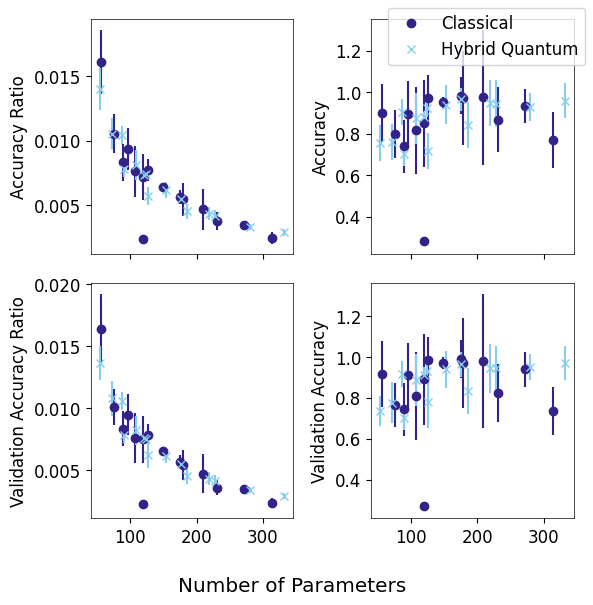

In [119]:
df_mean = copy.deepcopy(df)
df_mean['acc'] = df_mean['acc_max'].apply(lambda x: x[-1])
df_mean['acc_std'] = df_mean['acc_std'].apply(lambda x: x[-1])
df_mean['val_acc'] = df_mean['val_acc_max'].apply(lambda x: x[-1])
df_mean['val_acc_std'] = df_mean['val_acc_std'].apply(lambda x: x[-1])
df_mean['loss'] = df_mean['loss_max'].apply(lambda x: x[-1])
df_mean['loss_std'] = df_mean['loss_std'].apply(lambda x: x[-1])
df_mean['val_loss'] = df_mean['val_loss_max'].apply(lambda x: x[-1])
df_mean['val_loss_std'] = df_mean['val_loss_std'].apply(lambda x: x[-1])
df_mean['acc_ratio'] = df_mean['acc']/df_mean['num_params']
df_mean['acc_ratio_std'] = df_mean['acc_std']/df_mean['num_params']
df_mean['val_acc_ratio'] = df_mean['val_acc']/df_mean['num_params']
df_mean['val_acc_ratio_std'] = df_mean['val_acc_std']/df_mean['num_params']
df_classical = df_mean[df_mean['network_type']=='classical']
df_quantum = df_mean[df_mean['network_type']=='quantum']
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(6,6), sharex=True)

x,y = df_classical['num_params'], df_classical['acc_ratio']
axs[0,0].errorbar(x,y, yerr=df_classical['acc_ratio_std'], fmt='o',ecolor=colors[0], color=colors[0])
axs[0,0].set_ylabel('Accuracy Ratio')

x,y = df_quantum['num_params'], df_quantum['acc_ratio']
axs[0,0].errorbar(x,y,  yerr=df_quantum['acc_ratio_std'], fmt='x', color=colors[1])

x,y = df_classical['num_params'], df_classical['val_acc_ratio']
axs[1,0].errorbar(x,y, yerr=df_classical['val_acc_ratio_std'], fmt='o', color=colors[0])
axs[1,0].set_ylabel('Validation Accuracy Ratio')

x,y = df_quantum['num_params'], df_quantum['val_acc_ratio']
axs[1,0].errorbar(x,y, yerr=df_quantum['val_acc_ratio_std'], fmt='x', ecolor=colors[1], color=colors[1])

x,y = df_classical['num_params'], df_classical['acc']
axs[0,1].errorbar(x,y, yerr=df_classical['acc_std'], fmt='o', color=colors[0])
axs[0,1].set_ylabel('Accuracy')

x,y = df_quantum['num_params'], df_quantum['acc']
axs[0,1].errorbar(x,y, yerr=df_quantum['acc_std'], fmt='x', color=colors[1])

x,y = df_classical['num_params'], df_classical['val_acc']
axs[1,1].errorbar(x,y, yerr=df_classical['val_acc_std'], fmt='o', color=colors[0])
axs[1,1].set_ylabel('Validation Accuracy')

x,y = df_quantum['num_params'], df_quantum['val_acc']
axs[1,1].errorbar(x,y, yerr=df_quantum['val_acc_std'], fmt='x', color=colors[1])
fig.supxlabel('Number of Parameters')
plt.errorbar([], [], fmt='o', ecolor=colors[0], color=colors[0], label='Classical')
plt.errorbar([], [], fmt='x', color=colors[1], label='Hybrid Quantum')
fig.legend()
fig.tight_layout()

In [11]:

ex_path = "Synthetic_Hybrid_PWB_Experiment_Test2"
dbGen = ResultsDatabaseGenerator()
dbGen.initialize_from_folder(ex_path)
data = dbGen.data
config = data[6]['config']
config.pop('__doc__', None)
df = pd.DataFrame(columns=config.keys())
df['avg_acc'] = np.nan
df['acc_err'] = np.nan
df['avg_loss'] = np.nan
df['loss_err'] = np.nan
for i in range(1, len(data) + 1):
    try:
        config = data[i]['config']
        config.pop('__doc__', None)
        metrics = data[i]['metrics']
        metrics.pop('epoch',None)
        acc, loss = metrics.values()
        avg_acc = np.mean(acc)
        acc_err = np.std(acc)
        avg_loss = np.mean(loss)
        loss_err = np.std(loss)
        df.loc[i] = [*config.values(), avg_acc, acc_err, avg_loss, loss_err]
    except KeyError:
        print(f"Invalid: {i}")
   
x = np.array(df['sigma'].unique()).astype(float)
x = np.log2(1+1/x)
plot_df = pd.DataFrame(index=x)
df = df.sort_values('sigma')


ValueError: too many values to unpack (expected 2)

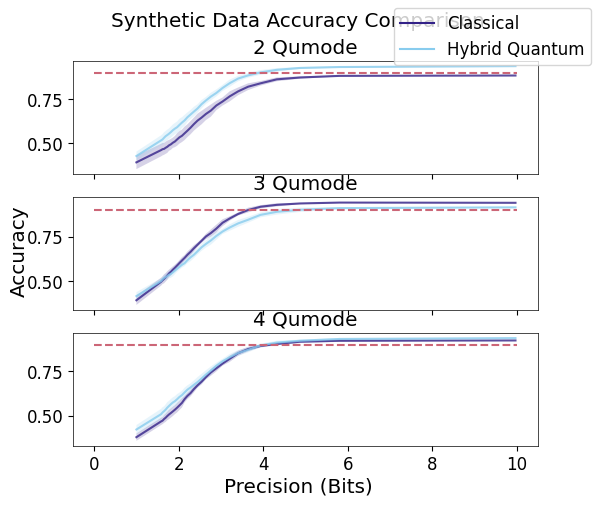

In [15]:
%matplotlib inline

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(6, 5), sharex='col', sharey='row')


for i in range(2,5):


    mask = (df['network_type']=='quantum') & (df['num_qumodes']==i)

    x1 = np.array(df[mask]['sigma'].unique()).astype(float)
    x1 = np.log2(1+1/x1)

    acc_q = df[mask]['avg_acc']
    acc_err_q = df[mask]['acc_err']
    loss_q = df[mask]['avg_loss']
    loss_err_q = df[mask]['loss_err']

    mask = (df['network_type']=='classical') & (df['num_qumodes']==i)

    x2 = np.array(df[mask]['sigma'].unique()).astype(float)
    x2 = np.log2(1+1/x2)
    
    acc_c = df[mask]['avg_acc']
    acc_err_c = df[mask]['acc_err']
    loss_c = df[mask]['avg_loss']
    loss_err_c = df[mask]['loss_err']    

    #ax[i-2].grid(True, linestyle=':')
    line_q = ax[i-2].plot(x1, acc_q, alpha=0.8)
    ax[i-2].fill_between(x1, acc_q - acc_err_q, acc_q + acc_err_q, interpolate=True, alpha=0.2)
    
    line_c = ax[i-2].plot(x2, acc_c, alpha=0.8)
    ax[i-2].fill_between(x2, acc_c - acc_err_c, acc_c + acc_err_c, interpolate=True, alpha=0.2)
    ax[i-2].set_title(f'{i} Qumode')
    ax[i-2].hlines(0.9, 0, 10, linestyles='--', color=colors[6]) 
plt.plot([], color=colors[0], label='Classical')
plt.plot([], color=colors[1], label='Hybrid Quantum')
fig.legend()
fig.supylabel('Accuracy')
fig.supxlabel('Precision (Bits)')
fig.suptitle('Synthetic Data Accuracy Comparison')
plt.savefig(f'../Plotting/Synthetic_comparison.pdf')
plt.show()

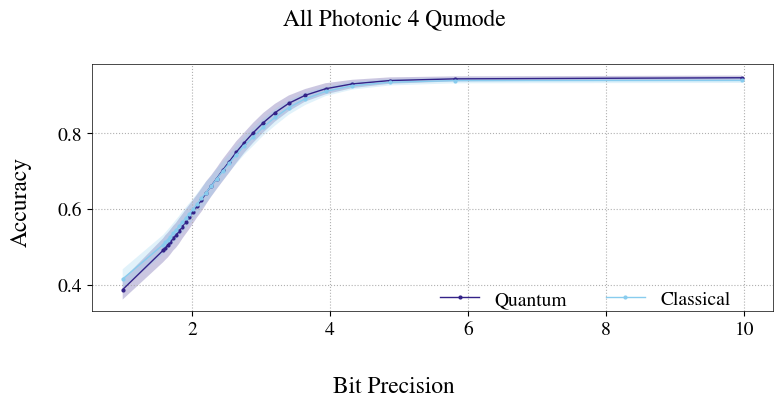

In [9]:
%matplotlib inline

for i in range(1, len(data) + 1):
    config = data[i]['config']
    config.pop('__doc__', None)
    metrics = data[i]['metrics']
    metrics.pop('epoch',None)
    acc, loss = metrics.values()
    avg_acc = np.mean(acc)
    acc_err = np.std(acc)
    avg_loss = np.mean(loss)
    loss_err = np.std(loss)
    df.loc[i] = [*config.values(), avg_acc, acc_err, avg_loss, loss_err]
   
    
df = df.sort_values('sigma')
x = np.array(df['sigma'].unique()).astype(float)
x = np.log2(1+1/x)
plot_df = pd.DataFrame(index=x)

mask = (df['network_type']=='quantum') & (df['num_qumodes']==4)
acc_q = df[mask]['avg_acc']
acc_err_q = df[mask]['acc_err']
loss_q = df[mask]['avg_loss']
loss_err_q = df[mask]['loss_err']

mask = (df['network_type']=='classical') & (df['num_qumodes']==4)

acc_c = df[mask]['avg_acc']
acc_err_c = df[mask]['acc_err']
loss_c = df[mask]['avg_loss']
loss_err_c = df[mask]['loss_err']

plot_df['Ph Q Acc 4'] = acc_q.values
plot_df['Ph Q Acc Err 4'] = acc_err_q.values
plot_df['Ph Q Loss 4'] = loss_q.values
plot_df['Ph Q Loss Err 4'] = loss_err_q.values
plot_df['Ph C Acc 4'] = acc_c.values
plot_df['Ph C Acc Err 4'] = acc_err_c.values
plot_df['Ph C Loss 4'] = loss_c.values
plot_df['Ph C Loss Err 4'] = loss_err_c.values

Plot = MultiPlot([x,x], 
                 [acc_q, acc_c],
                 'Bit Precision', 
                 'Accuracy', 
                 legend_name=['Quantum', 'Classical'], 
                 yerr=[acc_err_q, acc_err_c],
                 title='All Photonic 4 Qumode',
                 legend_position_x=0.5,
                 legend_position_y=-0.02)
Plot.options["figure_size_x"] = 8
Plot.options["figure_size_y"] = 4
Plot.plot()


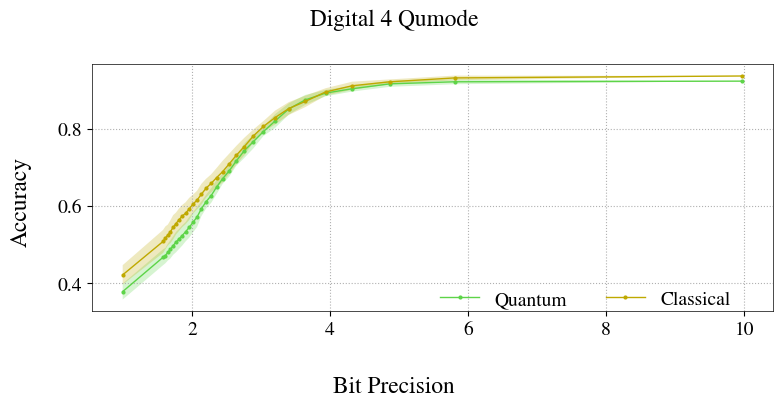

In [9]:
mask = (df['network_type']=='quantum') & (df['num_qumodes']==4)

acc_q = df[mask]['avg_acc']
acc_err_q = df[mask]['acc_err']
loss_q = df[mask]['avg_loss']
loss_err_q = df[mask]['loss_err']

mask = (df['network_type']=='classical') & (df['num_qumodes']==4)

acc_c = df[mask]['avg_acc']
acc_err_c = df[mask]['acc_err']
loss_c = df[mask]['avg_loss']
loss_err_c = df[mask]['loss_err']


plot_df['TF Q Acc 4'] = acc_q.values
plot_df['TF Q Acc Err 4'] = acc_err_q.values
plot_df['TF Q Loss 4'] = loss_q.values
plot_df['TF Q Loss Err 4'] = loss_err_q.values
plot_df['TF C Acc 4'] = acc_c.values
plot_df['TF C Acc Err 4'] = acc_err_c.values
plot_df['TF C Loss 4'] = loss_c.values
plot_df['TF C Loss Err 4'] = loss_err_c.values

Plot = MultiPlot([x,x], 
                 [acc_q, acc_c],
                 'Bit Precision', 
                 'Accuracy', 
                 legend_name=['Quantum', 'Classical'], 
                 yerr=[acc_err_q, acc_err_c],
                 title='Digital 4 Qumode',
                 legend_position_x=0.5,
                 legend_position_y=-0.02)
Plot.options["figure_size_x"] = 8
Plot.options["figure_size_y"] = 4
Plot.plot()

<Figure size 800x400 with 0 Axes>

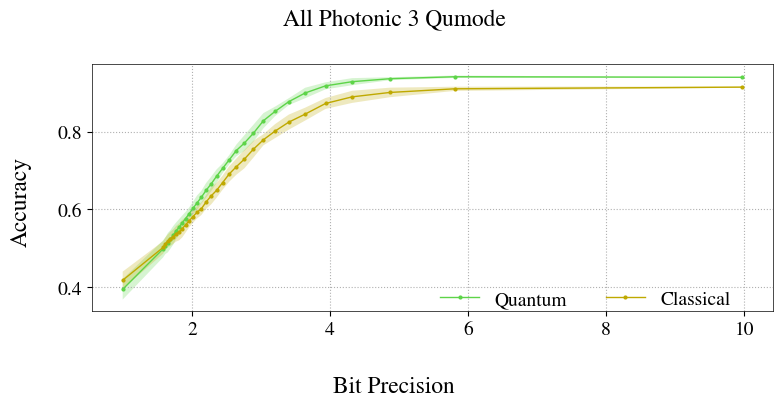

In [10]:
mask = (df['network_type']=='quantum') & (df['num_qumodes']==3)

acc_q = df[mask]['avg_acc']
acc_err_q = df[mask]['acc_err']
loss_q = df[mask]['avg_loss']
loss_err_q = df[mask]['loss_err']

mask = (df['network_type']=='classical') & (df['num_qumodes']==3)

acc_c = df[mask]['avg_acc']
acc_err_c = df[mask]['acc_err']
loss_c = df[mask]['avg_loss']
loss_err_c = df[mask]['loss_err']

plot_df['Ph Q Acc 3'] = acc_q.values
plot_df['Ph Q Acc Err 3'] = acc_err_q.values
plot_df['Ph Q Loss 3'] = loss_q.values
plot_df['Ph Q Loss Err 3'] = loss_err_q.values
plot_df['Ph C Acc 3'] = acc_c.values
plot_df['Ph C Acc Err 3'] = acc_err_c.values
plot_df['Ph C Loss 3'] = loss_c.values
plot_df['Ph C Loss Err 3'] = loss_err_c.values

fig = plt.figure(
        figsize= (
                8,4))

Plot = MultiPlot([x,x], 
                 [acc_q, acc_c],
                 'Bit Precision', 
                 'Accuracy', 
                 legend_name=['Quantum', 'Classical'], 
                 yerr=[acc_err_q, acc_err_c],
                 title='All Photonic 3 Qumode',
                 legend_position_x=0.5,
                 legend_position_y=-0.02)
Plot.options["figure_size_x"] = 8
Plot.options["figure_size_y"] = 4
Plot.plot()

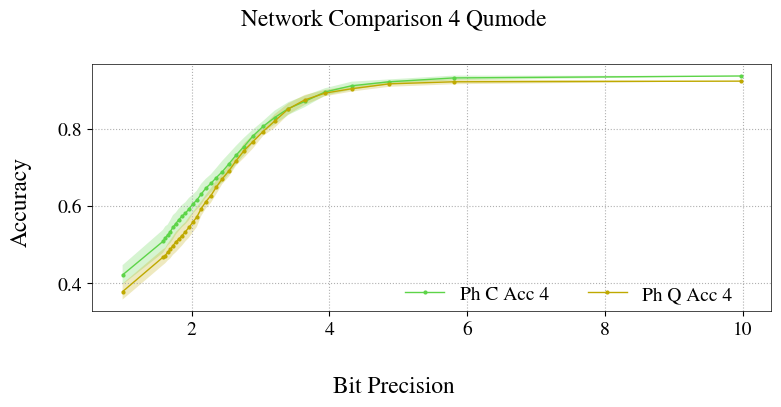

In [11]:
names = ['Ph C Acc 4', 'Ph Q Acc 4']
names_err = [n.split(' ') for n in names]
[names_err[i].insert(-1, 'Err') for i,n in enumerate(names_err)]
names_err = [" ".join(names_err[i]) for i,n in enumerate(names_err)]

Plot = MultiPlot([plot_df.index for i in names], 
                 plot_df[names].values.T,
                 'Bit Precision', 
                 'Accuracy', 
                 legend_name=[*names], 
                 yerr=plot_df[names_err].values.T,
                 title='Network Comparison 4 Qumode',
                 legend_position_x=0.45,
                 legend_position_y=0.0)
Plot.options["figure_size_x"] = 8
Plot.options["figure_size_y"] = 4
Plot.plot()

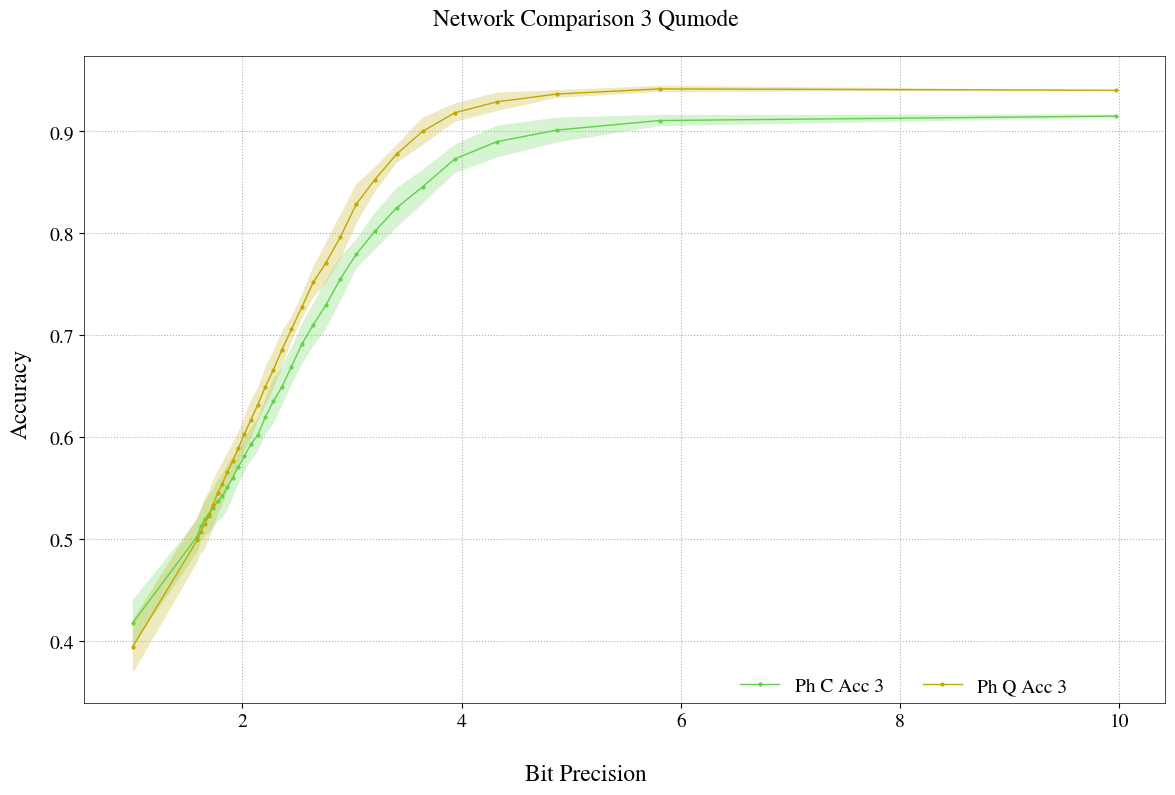

In [12]:
names = ['Ph C Acc 3', 'Ph Q Acc 3']
names_err = [n.split(' ') for n in names]
[names_err[i].insert(-1, 'Err') for i,n in enumerate(names_err)]
names_err = [" ".join(names_err[i]) for i,n in enumerate(names_err)]

Plot = MultiPlot([plot_df.index for i in names], 
                 plot_df[names].values.T,
                 'Bit Precision', 
                 'Accuracy', 
                 legend_name=[*names], 
                 yerr=plot_df[names_err].values.T,
                 title='Network Comparison 3 Qumode',
                 legend_position_x=0.6,
                 legend_position_y=0.0)
Plot.options["figure_size_x"] = 12
Plot.options["figure_size_y"] = 8
Plot.plot()

In [9]:
%matplotlib inline
from common_packages.CV_quantum_layers import Activation_Layer, CV_Measurement, QuantumLayer_MultiQunode
from PWBLayer_TF import PWBLinearLayer
from keras import Model, layers, models, regularizers
from common_packages.utilities import get_equivalent_classical_layer_size
from hybrid_base import EXPERIMENT_NAME as BASE_EXPERIMENT_NAME
from hybrid_base import LOSS_FUNCTION, NUM_EPOCHS, OPTIMIZER, RANDOM_SEED
import tensorflow as tf
from data import generate_synthetic_dataset
import copy
import json
from os import listdir
from os.path import isdir, join
from hybrid_pwb import get_config
from sklearn.metrics import ConfusionMatrixDisplay

network_type = 'classical'
num_qumodes = 4

class Net(Model):  # pylint: disable=W0223
        """Neural network model to train on"""

        def __init__(self):
            self._estimator_type='classifier'
            super().__init__()
            precision = int(2**15 - 1)
            self.base_model = models.Sequential(
                [
                    layers.Dense(20, activation="relu"),
                    layers.Dense(20, activation="relu"),
                    layers.Dense(2*num_qumodes, activation=None),
                ]
            )

            if network_type == "classical":
                self.quantum_substitue = models.Sequential(
                    [
                        layers.Dense(
                            get_equivalent_classical_layer_size(num_qumodes, 2 * num_qumodes, 3),
                            activation="relu",
                            bias_constraint=lambda t: tf.clip_by_value(t, -1.0, 1.0),
                            kernel_constraint=lambda t: tf.clip_by_value(t, -1.0, 1.0),
                        ),
                    ]
                )

            self.quantum_layer = QuantumLayer_MultiQunode(
                n_qumodes=num_qumodes,
                n_circuits=1,
                n_layers=1,
                cutoff_dim=3,
                encoding_method="Amplitude_Phase",
                regularizer=regularizers.L1(l1=0.1),
                max_initial_weight=0.15,
                measurement_object=CV_Measurement("X_quadrature"),
                shots=None,
            )

            self.quantum_preparation_layer = Activation_Layer("Sigmoid", self.quantum_layer.encoding_object)

            self.final_layer = models.Sequential([layers.Dense(3, activation="softmax")])

        def call(self, inputs):  # pylint: disable=W0221
            """Call the network"""
            output = self.base_model(inputs)
            if network_type == "quantum":
                output = self.quantum_preparation_layer(output)
                output = self.quantum_layer(output)
            elif network_type == "classical":
                output = self.quantum_substitue(output)
            else:
                raise ValueError("Invalid network type specified.")
            output = self.final_layer(output)
            output = tf.argmax(output, axis=1)
            return output

_, validate_data = generate_synthetic_dataset()
model = Net()
model.compile(optimizer=OPTIMIZER, loss=LOSS_FUNCTION, metrics=["accuracy"])
sub_folders = [folder for folder in listdir(BASE_EXPERIMENT_NAME) if isdir(join(BASE_EXPERIMENT_NAME, folder))]
experiment_numbers = [sub_folder for sub_folder in sub_folders if sub_folder.isdigit()]
target_experiment_path_list = []
predictions = []
for experiment_num in experiment_numbers:
    config = get_config(f"{BASE_EXPERIMENT_NAME}/{experiment_num}")
    if config["num_qumodes"] == num_qumodes and config["network_type"] == network_type:
        target_experiment_path_list.append(f"{BASE_EXPERIMENT_NAME}/{experiment_num}")

target_experiment_path = target_experiment_path_list[0]
model.load_weights(f"{target_experiment_path}/weights/weight{NUM_EPOCHS-1}.ckpt", by_name=False)

x = validate_data[0]
y = tf.argmax(validate_data[1], axis=-1)
fig = plt.figure(figsize=(1,1))
ConfusionMatrixDisplay.from_estimator(model, X=x, y=y)
plt.savefig('Synthetic_Confusion.pdf')
plt.show()

TypeError: ConfusionMatrixDisplay.from_estimator() got an unexpected keyword argument 'figsize'

<Figure size 100x100 with 0 Axes>